In [20]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# language family https://en.wikipedia.org/wiki/List_of_language_families
# language codes: https://en.wikipedia.org/wiki/List_of_ISO_639-5_codes
# ISO 639-1 to name, ISO 639-2, ISO 639-5 mapping: https://github.com/haliaeetus/iso-639 (data/iso_639-1.json)

! git clone https://github.com/haliaeetus/iso-639 ~/git/iso-639
! ls ~/git/iso-639

fatal: destination path '/private/home/shuohui/git/iso-639' already exists and is not an empty directory.
LICENSE  README.md  data  index.js  package.json  scrapers


## get data size by language

In [22]:
# get raw data size for each language, e.g.
! du -d 0 /large_experiments/xlmg/data/cc100_xl/ru_RU/0.3/raw/train

1007380359	/large_experiments/xlmg/data/cc100_xl/ru_RU/0.3/raw/train


In [23]:
sizes = ! du -d 0 /large_experiments/xlmg/data/cc100_xl/*/*/raw/train

In [24]:
df = {
    x[x.find("cc100_xl/") + len("cc100_xl/"):][: x[x.find("cc100_xl/") + len("cc100_xl/"):].find("/")] :
    {"size": int(x.split("\t")[0])}
    for x in sizes
}
df = pd.DataFrame(df).T
df["dialect"] = df.index
display(df.shape, df.head())

(134, 2)

,size,dialect
af_ZA,3040038,af_ZA
am_ET,850795,am_ET
ar_AR,64343785,ar_AR
ar_AR_rom,1654662,ar_AR_rom
as_IN,99483,as_IN


In [25]:
# from train.log files
upsampling_ratios = {
    'ar_AR': '0.0099', 'bg_BG': '0.0393', 'bn_IN': '0.0066', 
    'ca_ES': '0.0287', 'de_DE': '0.0363', 'el_GR': '0.0233', 
    'en_XX': '0.3259', 'es_XX': '0.0353', 'et_EE': '0.0133', 
    'eu_ES': '0.0043', 'fi_FI': '0.0681', 'fr_XX': '0.0313', 
    'hi_IN': '0.0140', 'ht_HT': '0.0035', 'id_ID': '0.0125', 
    'it_IT': '0.0171', 'ja_XX': '0.0269', 'ko_KR': '0.0811', 
    'my_MM': '0.0030', 'pt_XX': '0.0297', 'qu_PE': '0.0001', 
    'ru_RU': '0.0602', 'sw_KE': '0.0037', 'ta_IN': '0.0060', 
    'te_IN': '0.0028', 'th_TH': '0.0440', 'tr_TR': '0.0101', 
    'ur_PK': '0.0055', 'vi_VN': '0.0091', 'zh_CN': '0.0483'
}
for k in upsampling_ratios:
    upsampling_ratios[k] = float(upsampling_ratios[k])
ratios = pd.DataFrame(upsampling_ratios.items(), columns=["dialect", "upsampling"])
ratios.index = ratios.dialect.to_list()
del ratios["dialect"]

In [26]:
df = df.join(ratios).fillna(0)
df["in_pretraining"] = df.apply(lambda row: row.upsampling > 0, axis=1)
display(df.shape, df.head())

(134, 4)

,size,dialect,upsampling,in_pretraining
af_ZA,3040038,af_ZA,0.0000,False
am_ET,850795,am_ET,0.0000,False
ar_AR,64343785,ar_AR,0.0099,True
ar_AR_rom,1654662,ar_AR_rom,0.0000,False
as_IN,99483,as_IN,0.0000,False


## get tokens and ratios
- count tokens

In [27]:
import fnmatch
import os

path = "/large_experiments/xlmg/data/cc100_xl_unigram/intermediate_bin/"
matches = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, "preprocess.log"):
        matches.append(os.path.join(root, filename))
        
print(len(matches))
print(matches[-2:])

40201
['/large_experiments/xlmg/data/cc100_xl_unigram/intermediate_bin/shard299/qi_PH_rom/preprocess.log', '/large_experiments/xlmg/data/cc100_xl_unigram/intermediate_bin/shard299/da_DK/preprocess.log']


In [28]:
matched_lines = []
for file in matches:
    with open(file) as f:
        lines = f.readlines()
        matched_lines.extend([x for x in lines if "sents," in x and "tokens," in x and "train_tokens" in x])
        
matched_lines = list(set(matched_lines))
matched_lines.sort()
print(len(matched_lines))

40203


In [29]:
print(len(matched_lines))
print(matched_lines[-2:])

40203
['[None] /large_experiments/xlmg/data/cc100_xl_unigram/bped/shard99/zh_TW/train_tokens.txt: 826757 sents, 43657337 tokens, 1.86% replaced by <unk>\n', '[None] /large_experiments/xlmg/data/cc100_xl_unigram/bped/shard99/zu_ZA/train_tokens.txt: 1337 sents, 122011 tokens, 0.0% replaced by <unk>\n']


In [30]:
import re

tokens = []
regex1 = re.compile(r'shard[0-9]+/([^/]+)')
regex2 = re.compile(r'shard([0-9]+)/')
regex3 = re.compile(r'([0-9]+) tokens')

for text in matched_lines:
    tokens.append(regex1.findall(text) + regex2.findall(text) + regex3.findall(text))
d1 = pd.DataFrame(tokens, columns=["dialect", "shard", "tokens"])
d1 = d1.astype({"shard": int, "tokens": int})
display(d1.shape, d1.head(2))
display(d1[(d1.dialect!="en_XX") | (d1.tokens > 2000000000)].sort_values(by="shard").shape)

d2 = d1[(d1.dialect!="en_XX") | (d1.tokens > 2000000000)].groupby(["dialect"]).agg(["count", "sum"]).reset_index()
d2.columns = ["_".join(x) if x[1] else x[0] for x in d2.columns]
display(d2.shape, d2[d2.iloc[:,1] != 300])
d2 = d2.sort_values(by=["tokens_sum"], ascending=False)
d2.index = d2.dialect.to_list()
d2 = d2.join(df[["in_pretraining", "upsampling"]])
del d2["shard_sum"]
del d2["tokens_count"]
display(d2)

(40203, 3)

,dialect,shard,tokens
0,af_ZA,0,2723238
1,am_ET,0,554542


(40200, 3)

(134, 5)

,dialect,shard_count,shard_sum,tokens_count,tokens_sum


,dialect,shard_count,tokens_sum,in_pretraining,upsampling
en_XX,en_XX,300,803526736124,True,0.3259
ru_RU,ru_RU,300,147791898098,True,0.0602
zh_CN,zh_CN,300,119622930895,True,0.0483
de_DE,de_DE,300,89223707856,True,0.0363
es_XX,es_XX,300,87303083105,True,0.0353
...,...,...,...,...,...
ss_SZ,ss_SZ,300,1593407,False,0.0000
qw_KE,qw_KE,300,1513101,False,0.0000
qa_MM,qa_MM,300,846704,False,0.0000
qp_AO,qp_AO,300,696501,False,0.0000


- add language code

In [31]:
import json
from pprint import pprint

iso = json.load(open("iso-639/data/iso_639-1.json"))
print(len(iso))
pprint(iso["en"])

iso = pd.DataFrame(iso).T[["639-1", "family", "name"]]

d2.index = [x.split("_")[0]+"_rom" if x.endswith("rom") else x.split("_")[0] for x in d2.dialect]
d2 = d2.join(iso)
d2["639-1"] = d2["639-1"].fillna("zz")
d2 = d2.fillna("Unassigned")
d2["639-1"] = d2.apply(lambda row: row.dialect.split("_")[0]+"_rom" if row.dialect.endswith("rom") else row["639-1"], axis=1)

display(d2.shape, d2.head(2))
display(d2[[x.endswith("rom") for x in d2.dialect]].shape, 
        d2[[x.endswith("rom") for x in d2.dialect]].head(2))

184
{'639-1': 'en',
 '639-2': 'eng',
 'family': 'Indo-European',
 'name': 'English',
 'nativeName': 'English',
 'wikiUrl': 'https://en.wikipedia.org/wiki/English_language'}


(134, 8)

,dialect,shard_count,tokens_sum,in_pretraining,upsampling,639-1,family,name
af,af_ZA,300,818752284,False,0.0,af,Indo-European,Afrikaans
am,am_ET,300,168713911,False,0.0,am,Afro-Asiatic,Amharic


(8, 8)

,dialect,shard_count,tokens_sum,in_pretraining,upsampling,639-1,family,name
ar_rom,ar_AR_rom,300,685308147,False,0.0,ar_rom,Unassigned,Unassigned
bn_rom,bn_IN_rom,300,166304963,False,0.0,bn_rom,Unassigned,Unassigned


In [32]:
d2b = d2.groupby(["639-1", "family", "name"]).sum()[["tokens_sum", "in_pretraining"]].reset_index()
d2b.in_pretraining = d2b.apply(lambda row: row.in_pretraining > 0, axis=1)
d2b.index = d2b["639-1"].to_list()
display(d2b.shape, d2b.head(2))

(116, 5)

,639-1,family,name,tokens_sum,in_pretraining
af,af,Indo-European,Afrikaans,818752284,False
am,am,Afro-Asiatic,Amharic,168713911,False


In [33]:
d3 = d2b.copy()
d3.index = d3["639-1"].tolist()
d3 = d3[d3.in_pretraining]
display(d3.shape, d3.head(2))

(30, 5)

,639-1,family,name,tokens_sum,in_pretraining
ar,ar,Afro-Asiatic,Arabic,12248607345,True
bg,bg,Indo-European,Bulgarian,9703797869,True


- get gpt-3 ratios

In [34]:
# ! git clone https://github.com/openai/gpt-3

In [35]:
gpt3 = pd.read_csv("~/git/gpt-3/dataset_statistics/languages_by_word_count.csv")
gpt3["percentage"] = [float(x.replace("%", ""))/100 for x in gpt3["percentage of total words"]]
gpt3.index = gpt3.language.to_list()
del gpt3["language"]
del gpt3["percentage of total words"]
display(gpt3.shape, gpt3.head(2))

d3 = d3.join(gpt3).fillna(0).sort_values(by=["tokens_sum"], ascending=False)

xlmg_en = f'{d3[d3["639-1"]=="en"].tokens_sum.to_list()[0] / d3.tokens_sum.sum() * 100:.1f}%'
gpt3_en = f'{d3[d3["639-1"]=="en"].percentage.to_list()[0] * 100:.1f}%'
print(xlmg_en, gpt3_en)

d3["percentage"] = d3.apply(lambda row: row.percentage * 100, axis=1)
d3["xlmg_ratio"] = d3.apply(
    lambda row: row.tokens_sum / d3.tokens_sum.sum() * 100, axis=1
)
display(d3.shape, d3.head(2))

(118, 2)

,number of words,percentage
en,181014683608,0.926471
fr,3553061536,0.018185


49.0% 92.6%


(30, 8)

,639-1,family,name,tokens_sum,in_pretraining,number of words,percentage,xlmg_ratio
en,en,Indo-European,English,803526736124,True,1.810147e+11,92.64708,48.990566
ru,ru,Indo-European,Russian,147791898098,True,3.681571e+08,0.18843,9.010788


In [93]:
ratios.index = [x.split("_")[0] for x in ratios.index]
ratios.upsampling = ratios.upsampling * 100
upsamp_en = f'{ratios[ratios.index=="en"].upsampling.to_list()[0]:.1f}%'
print(upsamp_en)

d3b = d3.copy().join(ratios)
d3b["xlmg_ratio"] = d3b.apply(lambda row: 5+2*row.xlmg_ratio/row.percentage if row["639-1"]=="en" else row.xlmg_ratio, axis=1)
d3b["upsampling"] = d3b.apply(lambda row: 5+2*row.upsampling/row.percentage if row["639-1"]=="en" else row.upsampling, axis=1)
d3b["percentage"] = d3b.apply(lambda row: 7. if row["639-1"]=='en' else row.percentage, axis=1)
display(d3b.shape, d3b.head(2))

32.6%


(30, 9)

,639-1,family,name,tokens_sum,in_pretraining,number of words,percentage,xlmg_ratio,upsampling
en,en,Indo-European,English,803526736124,True,1.810147e+11,7.00000,6.057574,5.70353
ru,ru,Indo-European,Russian,147791898098,True,3.681571e+08,0.18843,9.010788,6.02000


## make plots
- sort and plot by pre-sharding ratio of XLM-G

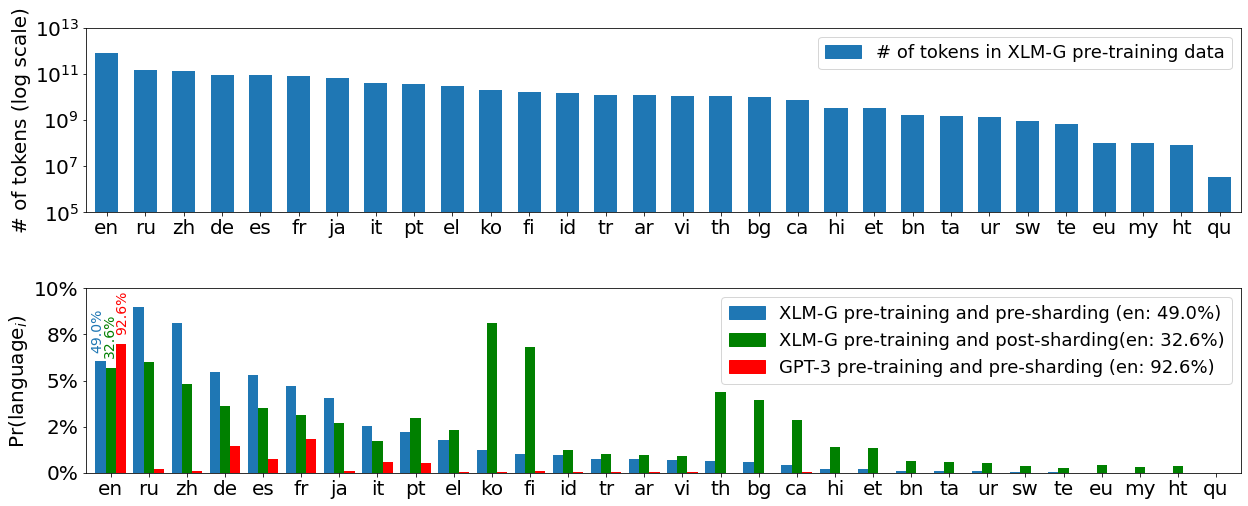

In [96]:
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))
fig.tight_layout(pad=5.5)

g1 = d3b[["tokens_sum"]].sort_values(by=["tokens_sum"], ascending=False).plot(
    kind="bar", stacked=True, width=0.6, align="center",
    ylabel="tokens",
    ylim=(1e5, 1e13),
    fontsize=20,
    color={
        "tokens_sum": 'C0',
    },
    ax=axs[0],
).set_yscale("log")

g2 = d3b.sort_values(by=["tokens_sum"], ascending=False)[["xlmg_ratio", "upsampling", "percentage"]].plot(
    kind="bar",
    ylim=(0, 10),
    fontsize=20,
    width=0.8,
    color={
        "xlmg_ratio": 'C0',
        "percentage": 'red',
        "upsampling": 'green',
    },
    ax=axs[1],
).grid(False)

axs[0].grid(False)
axs[0].set_ylabel("# of tokens (log scale)", fontsize=20)
# axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_major_locator(ticker.LogLocator(base=10, numticks=5))
axs[0].get_yaxis().set_minor_locator(ticker.NullLocator())
axs[0].tick_params(bottom=True, left=True)
axs[0].tick_params(labelbottom=True, labelleft=True, labeltop=False, labelright=False)
axs[0].tick_params(axis="x", labelrotation=0)
# axs[0].get_legend().remove()
axs[0].legend(handles=[
    mpatches.Patch(color='C0', label='# of tokens in XLM-G pre-training data'),
], loc=1, fontsize=18)

axs[1].grid(False)
# axs[1].set_ylabel("% of tokens (words)", fontsize=20)
axs[1].set_ylabel("Pr(language$_i$)", fontsize=20)
axs[1].tick_params(bottom=True, left=True)
axs[1].tick_params(labelbottom=True, labelleft=True, labeltop=False, labelright=False)
axs[1].tick_params(axis="x", labelrotation=0)
axs[1].legend(handles=[
    mpatches.Patch(color='C0', label=f'XLM-G pre-training and pre-sharding (en: {xlmg_en})'),
    mpatches.Patch(color='green', label=f'XLM-G pre-training and post-sharding(en: {upsamp_en})'),
    mpatches.Patch(color='red', label=f'GPT-3 pre-training and pre-sharding (en: {gpt3_en})'),
], loc=1, fontsize=18)
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
axs[1].yaxis.set_minor_formatter(ticker.NullFormatter())
axs[1].yaxis.set_major_locator(ticker.MaxNLocator(4))
# axs[1].yaxis.set_major_locator(ticker.FixedLocator([0, 2, 4, 6]))

y = d3b["tokens_sum"].to_list()
_ = axs[1].text(y[0]/1e13-0.6, 6.5, xlmg_en, color='C0', # fontweight='bold', 
                size=14, ha='left', va='bottom', rotation=90)
_ = axs[1].text(y[0]/1e13-0.1, 6.2, upsamp_en, color='green', # fontweight='bold', 
                size=14, ha='center', va='bottom', rotation=90)
_ = axs[1].text(y[0]/1e13+0.4, 7.5, gpt3_en, color='red', # fontweight='bold', 
                size=14, ha='right', va='bottom', rotation=90)

In [38]:
d4 = d3[["xlmg_ratio", "percentage"]]\
.sort_values(by=["xlmg_ratio"], ascending=False)\
.reset_index()\
.rename(columns={"index": "language"})

pd.concat([
    d4[:int(d4.shape[0]/2)].reset_index(drop=True),
    d4[int(d4.shape[0]/2):].reset_index(drop=True)
], axis=1)

,language,xlmg_ratio,percentage,language,xlmg_ratio,percentage
0,en,48.990566,92.64708,vi,0.682804,0.04252
1,ru,9.010788,0.18843,th,0.661041,0.01372
2,zh,8.094941,0.09905,bg,0.591635,0.00303
3,de,5.439918,1.46937,ca,0.431410,0.01798
4,es,5.322819,0.77289,hi,0.210246,0.00483
5,fr,4.720231,1.81853,et,0.200399,0.01060
6,ja,4.027297,0.11109,bn,0.099225,0.00154
7,it,2.556476,0.60793,ta,0.090050,0.00264
8,pt,2.230629,0.52483,ur,0.082424,0.00035
9,el,1.753613,0.03153,sw,0.055331,0.00030


In [97]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('/tmp/pretraining_data_30.pdf') as export_pdf:
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))
    fig.tight_layout(pad=5.5)

    g1 = d3b[["tokens_sum"]].sort_values(by=["tokens_sum"], ascending=False).plot(
        kind="bar", stacked=True, width=0.6, align="center",
        ylabel="tokens",
        ylim=(1e5, 1e13),
        fontsize=20,
        color={
            "tokens_sum": 'C0',
        },
        ax=axs[0],
    ).set_yscale("log")

    g2 = d3b.sort_values(by=["tokens_sum"], ascending=False)[["xlmg_ratio", "upsampling", "percentage"]].plot(
        kind="bar",
        ylim=(0, 10),
        fontsize=20,
        width=0.8,
        color={
            "xlmg_ratio": 'C0',
            "percentage": 'red',
            "upsampling": 'green',
        },
        ax=axs[1],
    ).grid(False)

    axs[0].grid(False)
    axs[0].set_ylabel("# of tokens (log scale)", fontsize=20)
    # axs[0].get_xaxis().set_ticks([])
    axs[0].get_yaxis().set_major_locator(ticker.LogLocator(base=10, numticks=5))
    axs[0].get_yaxis().set_minor_locator(ticker.NullLocator())
    axs[0].tick_params(bottom=True, left=True)
    axs[0].tick_params(labelbottom=True, labelleft=True, labeltop=False, labelright=False)
    axs[0].tick_params(axis="x", labelrotation=0)
    # axs[0].get_legend().remove()
    axs[0].legend(handles=[
        mpatches.Patch(color='C0', label='# of tokens in XLM-G pre-training data'),
    ], loc=1, fontsize=18)

    axs[1].grid(False)
    # axs[1].set_ylabel("% of tokens (words)", fontsize=20)
    axs[1].set_ylabel("Pr(language$_i$)", fontsize=20)
    axs[1].tick_params(bottom=True, left=True)
    axs[1].tick_params(labelbottom=True, labelleft=True, labeltop=False, labelright=False)
    axs[1].tick_params(axis="x", labelrotation=0)
    axs[1].legend(handles=[
        mpatches.Patch(color='C0', label=f'XLM-G pre-training and pre-sharding (en: {xlmg_en})'),
        mpatches.Patch(color='green', label=f'XLM-G pre-training and post-sharding(en: {upsamp_en})'),
        mpatches.Patch(color='red', label=f'GPT-3 pre-training and pre-sharding (en: {gpt3_en})'),
    ], loc=1, fontsize=18)
    axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    axs[1].yaxis.set_minor_formatter(ticker.NullFormatter())
    axs[1].yaxis.set_major_locator(ticker.MaxNLocator(4))
    # axs[1].yaxis.set_major_locator(ticker.FixedLocator([0, 2, 4, 6]))

    y = d3b["tokens_sum"].to_list()
    _ = axs[1].text(y[0]/1e13-0.6, 6.5, xlmg_en, color='C0', # fontweight='bold', 
                    size=14, ha='left', va='bottom', rotation=90)
    _ = axs[1].text(y[0]/1e13-0.1, 6.2, upsamp_en, color='green', # fontweight='bold', 
                    size=14, ha='center', va='bottom', rotation=90)
    _ = axs[1].text(y[0]/1e13+0.38, 7.5, gpt3_en, color='red', # fontweight='bold', 
                    size=14, ha='right', va='bottom', rotation=90)

    plt.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.98)
    export_pdf.savefig()
    plt.close()

### print labex table

In [40]:
import json
from pprint import pprint

iso = json.load(open("iso-639/data/iso_639-1.json"))
print(len(iso))
pprint(iso["en"])

iso = pd.DataFrame(iso).T[["639-1", "family", "name"]]
display(iso.shape, iso.head(2))

# fix Romanized langs
df1 = df.copy()
df1.index = [x.split("_")[0]+"_rom" if x.endswith("rom") else x.split("_")[0] for x in df1.dialect]
df1 = df1.join(iso)
df1["639-1"] = df1["639-1"].fillna("zz")
df1 = df1.fillna("Unassigned")
df1["639-1"] = df1.apply(lambda row: row.dialect.split("_")[0]+"_rom" if row.dialect.endswith("rom") else row["639-1"], axis=1)
display(df1.shape, df1.head(2))

display(df1[[x.endswith("rom") for x in df1.dialect]].shape, 
        df1[[x.endswith("rom") for x in df1.dialect]])

# fix a few lang name variations
df1["639-1"] = df1["639-1"]
df1["name"] = df1.apply(lambda row: re.sub(r"\(.+\)", "", row["name"]).split(",")[0].strip(), axis=1)

# fix unassigned Romanized langs
df1["name"] = df1.apply(
    lambda row: df1[df1.index == row["639-1"].split("_")[0]]["name"].to_list()[0] + " Romanized"
    if "_rom" in row["639-1"] and df1[df1.index == row["639-1"].split("_")[0]]["name"].to_list()
    else row["name"],
    axis=1
)
df1["639-1"] = df1.apply(
    lambda row: "zz"
    if "_rom" in row["639-1"] and not df1[df1.index == row["639-1"].split("_")[0]].name.to_list()
    else row["639-1"], 
    axis=1
)
df1.index = df1["639-1"].to_list()
display(df1.shape, df1.head(2))
display(df1[[x.endswith("rom") for x in df1.dialect]].shape, 
        df1[[x.endswith("rom") for x in df1.dialect]])

display(df1[df1["639-1"] == "zz"])

184
{'639-1': 'en',
 '639-2': 'eng',
 'family': 'Indo-European',
 'name': 'English',
 'nativeName': 'English',
 'wikiUrl': 'https://en.wikipedia.org/wiki/English_language'}


(184, 3)

,639-1,family,name
aa,aa,Afro-Asiatic,Afar
ab,ab,Northwest Caucasian,Abkhaz


(134, 7)

,size,dialect,upsampling,in_pretraining,639-1,family,name
af,3040038,af_ZA,0.0,False,af,Indo-European,Afrikaans
am,850795,am_ET,0.0,False,am,Afro-Asiatic,Amharic


(8, 7)

,size,dialect,upsampling,in_pretraining,639-1,family,name
ar_rom,1654662,ar_AR_rom,0.0,False,ar_rom,Unassigned,Unassigned
bn_rom,478488,bn_IN_rom,0.0,False,bn_rom,Unassigned,Unassigned
hi_rom,6597165,hi_IN_rom,0.0,False,hi_rom,Unassigned,Unassigned
qi_rom,5653,qi_PH_rom,0.0,False,qi_rom,Unassigned,Unassigned
ql_rom,11477,ql_ML_rom,0.0,False,ql_rom,Unassigned,Unassigned
ta_rom,125856,ta_IN_rom,0.0,False,ta_rom,Unassigned,Unassigned
te_rom,113634,te_IN_rom,0.0,False,te_rom,Unassigned,Unassigned
ur_rom,731109,ur_PK_rom,0.0,False,ur_rom,Unassigned,Unassigned


(134, 7)

,size,dialect,upsampling,in_pretraining,639-1,family,name
af,3040038,af_ZA,0.0,False,af,Indo-European,Afrikaans
am,850795,am_ET,0.0,False,am,Afro-Asiatic,Amharic


(8, 7)

,size,dialect,upsampling,in_pretraining,639-1,family,name
ar_rom,1654662,ar_AR_rom,0.0,False,ar_rom,Unassigned,Arabic Romanized
bn_rom,478488,bn_IN_rom,0.0,False,bn_rom,Unassigned,Bengali Romanized
hi_rom,6597165,hi_IN_rom,0.0,False,hi_rom,Unassigned,Hindi Romanized
zz,5653,qi_PH_rom,0.0,False,zz,Unassigned,Unassigned
zz,11477,ql_ML_rom,0.0,False,zz,Unassigned,Unassigned
ta_rom,125856,ta_IN_rom,0.0,False,ta_rom,Unassigned,Tamil Romanized
te_rom,113634,te_IN_rom,0.0,False,te_rom,Unassigned,Telugu Romanized
ur_rom,731109,ur_PK_rom,0.0,False,ur_rom,Unassigned,Urdu Romanized


,size,dialect,upsampling,in_pretraining,639-1,family,name
zz,1669732,cb_IQ,0.0,False,zz,Unassigned,Unassigned
zz,101400,ci_IT,0.0,False,zz,Unassigned,Unassigned
zz,257425,cx_PH,0.0,False,zz,Unassigned,Unassigned
zz,44897,ns_ZA,0.0,False,zz,Unassigned,Unassigned
zz,13041,q3_CV,0.0,False,zz,Unassigned,Unassigned
zz,5826,qa_MM,0.0,False,zz,Unassigned,Unassigned
zz,16655,qd_MM,0.0,False,zz,Unassigned,Unassigned
zz,25834,qf_CM,0.0,False,zz,Unassigned,Unassigned
zz,77535,qh_PH,0.0,False,zz,Unassigned,Unassigned
zz,5653,qi_PH_rom,0.0,False,zz,Unassigned,Unassigned


In [41]:
display(df1[(df1["name"] == "Unassigned") | (df1["639-1"] == "zz")].shape)
d0 = df1[~(df1["name"] == "Unassigned") & ~(df1["639-1"] == "zz")]
display(d0.shape)
display(df1.groupby(["639-1", "name"]).count()[["size", "in_pretraining"]].reset_index().shape)
d1 = df1.groupby(["639-1", "name"]).count()[["size"]].reset_index()
d1[d1["size"] > 1]

(18, 7)

(116, 7)

(114, 4)

,639-1,name,size
5,az,Azerbaijani,2
69,my,Burmese,2
111,zh,Chinese,2
113,zz,Unassigned,18


In [42]:
df1 = df1.groupby(["639-1", "name"]).sum()[["size", "in_pretraining"]].reset_index()
df1.in_pretraining = df1.apply(lambda row: row.in_pretraining > 0, axis=1)
df1["ISO code"] = df1["639-1"]
df1["Language"] = df1["name"]
df1.index = df1["639-1"].to_list()
display(df1.shape, df1.head(2))

(114, 6)

,639-1,name,size,in_pretraining,ISO code,Language
af,af,Afrikaans,3040038,False,af,Afrikaans
am,am,Amharic,850795,False,am,Amharic


In [43]:
df2 = df1[["ISO code", "Language", "size"]].join(d2b[["tokens_sum"]]).sort_values(by=["tokens_sum"], ascending=False)
df2["Tokens (M)"] = df2.apply(lambda row: f"{row.tokens_sum/1000000:,.0f}", axis=1)
# df2[-4:]["Size (GiB)"] = df2[-4:].apply(lambda row: f"{row['size']/1000000:,.3f}", axis=1)
df2["Size (GiB)"] = df2.apply(lambda row: f"{row['size']/1000000:,.2f}", axis=1)

df2["ISO code"] = df2.apply(
    lambda row: "-" if "_rom" in row["ISO code"] or "zz" in row["ISO code"] else row["ISO code"], 
    axis=1
)
display(df2[df2.apply(lambda row: "-" == row["ISO code"], axis=1)])

df2 = pd.concat([
    df2[~df2.Language.isin(["Unassigned"])],
    df2[df2.Language.isin(["Unassigned"])]
])

df2 = pd.concat([
    df2[["ISO code", "Language", "Tokens (M)", "Size (GiB)"]][:int(df2.shape[0]/2)].reset_index(drop=True),
    df2[["ISO code", "Language", "Tokens (M)", "Size (GiB)"]][int(df2.shape[0]/2):].reset_index(drop=True)
], axis=1)
print(df2.to_latex(index=False))

,ISO code,Language,size,tokens_sum,Tokens (M),Size (GiB)
hi_rom,-,Hindi Romanized,6597165,2045384531,"2,045",6.60
ar_rom,-,Arabic Romanized,1654662,685308147,685,1.65
zz,-,Unassigned,2299950,503167858,503,2.30
ur_rom,-,Urdu Romanized,731109,245276986,245,0.73
bn_rom,-,Bengali Romanized,478488,166304963,166,0.48
ta_rom,-,Tamil Romanized,125856,40491657,40,0.13
te_rom,-,Telugu Romanized,113634,36797857,37,0.11


\begin{tabular}{llllllll}
\toprule
ISO code &        Language & Tokens (M) & Size (GiB) & ISO code &          Language & Tokens (M) & Size (GiB) \\
\midrule
      en &         English &    803,527 &   3,324.45 &        - &  Arabic Romanized &        685 &       1.65 \\
      ru &         Russian &    147,792 &   1,007.38 &       mn &         Mongolian &        681 &       4.26 \\
      zh &         Chinese &    132,770 &     485.32 &       la &             Latin &        635 &       2.20 \\
      de &          German &     89,224 &     369.30 &       ne &            Nepali &        600 &       5.32 \\
      es &         Spanish &     87,303 &     363.83 &       si &         Sinhalese &        524 &       3.96 \\
      fr &          French &     77,420 &     303.76 &       mr &           Marathi &        458 &       3.59 \\
      ja &        Japanese &     66,054 &     293.39 &       kn &           Kannada &        446 &       3.41 \\
      it &         Italian &     41,930 &     170.76

In [44]:
display(df.shape, df1.shape, df2.shape, df1["size"].sum()/1e6, d2b.tokens_sum.sum()/1e9)

(134, 4)

(114, 6)

(57, 8)

8396.521261

1890.050743941